# 04: Inference

In this notebook, we'll use the trained model to make predictions on new NAIP imagery.

In [49]:
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import rasterio

from naip_cnn.inference import parse_imagery_tfrecord, load_mixer_as_profile

## Load the Model

First, we'll load and inspect the previously trained model.

In [50]:
MODEL_ID = "MAL2016_CanyonCreek_cover_RGBN_UNet"
model = tf.keras.models.load_model(f"../models/model_{MODEL_ID}.keras")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      1184      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 82944)             0         
                                                                 
 dense_4 (Dense)             (None, 25)               

## Run Inference

Inference is run on NAIP images that were exported as TFRecords in the previous notebook. Before continuing, make sure to wait for all Earth Engine exports to complete (you can check progress in the [task manager](https://code.earthengine.google.com/tasks)). Then, all `tfrecord.gz` files and the associated `mixer.json` should be downloaded from Google Drive to a data directory defined in the next step. Once those files are in local storage, we can start generating predictions.

### Load Metadata

The `mixer.json` that was exported by Earth Engine is a sidecar file that includes spatial reference metadata associated with the exported TFRecords. After generating predictions, we'll need that metadata to export the predictions back to a georeferenced raster image. We'll load and parse that first.

In [51]:
DATA_DIR = Path("../data/naip/2016")

mixer_path = next(DATA_DIR.glob("*.json"))
profile = load_mixer_as_profile(mixer_path)

### Parse the TFRecords

The images are serialized into TFRecord files and need to be parsed back into image tensors before the model can interact with them to generate predictions. The `parse_imagery_tfrecord` function does the heavy lifting of converting each serialized example into an image tensor, so we just need to map that over the appropriate files and batch the result.

In [52]:
batch_size = 512
n_batches = np.ceil((profile["width"] * profile["height"]) / batch_size)
tfrecords = list(DATA_DIR.glob("*.tfrecord.gz"))
image = (
    tf.data.TFRecordDataset(tfrecords, compression_type="GZIP")
    .map(parse_imagery_tfrecord)
    .batch(batch_size)
)

### Generate Predictions

Now we can use the model to generate predictions on the input images. The predictions will be a flat array which we'll reshape back into a 2D image.

In [53]:
pred = model.predict(image, steps=n_batches, verbose=1)
# Note: our tile size is 150x150 and our output resolution is 30x30, so need to multiply by 5
pred = (
    pred.reshape(profile["height"], profile["width"], 5, 5)
    .swapaxes(1, 2)
    .reshape(profile["height"] * 5, profile["width"] * 5)
)

211/211 [==============================] - 71s 335ms/step


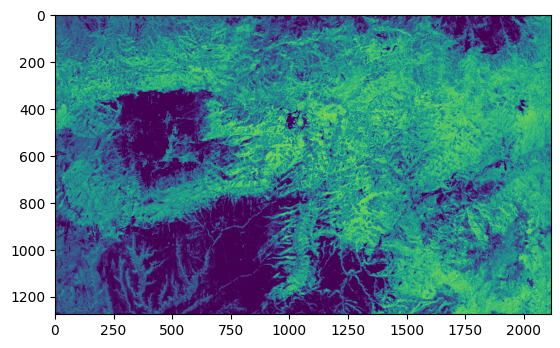

In [54]:
plt.imshow(pred, vmin=0, vmax=100)

## Export Predictions

Finally, we can export the predicted map to a raster image by using the `profile` we parsed from the JSON file.

In [55]:
# Rescale the output resolution from 1m to 30m
profile["transform"][0] = 30
profile["transform"][4] = 30
profile["width"] = profile["width"] * (150 / 30)
profile["height"] = profile["height"] * (150 / 30)

profile.update(
    dtype=np.float32,
    count=1,
    compress="DEFLATE",
    nodata=255,
)

with rasterio.open(f"../data/pred/malheur_2016_{MODEL_ID}.tif", "w", **profile) as dst:
    dst.write(pred, 1)